In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from utils import loadSequential, loadTabular, getDataloaders, train, dumpSubmission, useSeqTab, getJoinPred
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
tabular_train, labels = loadTabular(cleaned=False)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lin_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lin_input = nn.Linear(hidden_size, lin_size)
        self.lin_output = nn.Linear(lin_size, output_size)
        self.drop = nn.Dropout(p=0.3)
        self.soft = nn.Softmax(dim=1)
    
    def forward(self, sequence):
        hidden_cell = (torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double),
                        torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double))
        lstm_out, _ = self.lstm(sequence, hidden_cell)
        output = F.relu(self.lin_input(lstm_out[:, -1, :]))
        output = self.soft(self.lin_output(self.drop(output)))
        return output
    
    def features_vector(self, sequence):
        hidden_cell = (torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double),
                        torch.zeros(self.num_layers, sequence.shape[0], self.hidden_size).type(torch.double))
        lstm_out, _ = self.lstm(sequence, hidden_cell)
        output = F.relu(self.lin_input(lstm_out[:, -1, :]))
        return output

In [4]:
seq_model = LSTM(9, 32, 2, 64, 6).double()
#seq_model.load_state_dict(torch.load(os.path.join('models', 'fullLSTM')))
#seq_model.eval()

In [5]:
sequences_train = loadSequential()
train_dataloader, test_dataloader = getDataloaders(sequences_train, labels, split=0.25, batch_size=100)

epoch: 1000 time: 12123.35
Loss: 1.19263 accuracy: 0.84929


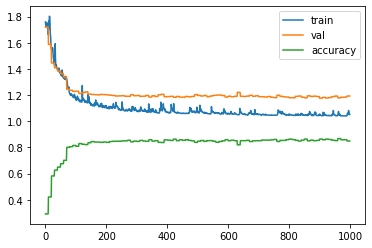

In [6]:
train(seq_model, train_dataloader, test_dataloader, 1000, show_every=10, save=True, name='bigger_lstm_dropout')

In [7]:
ss = StandardScaler()
tabular_train = ss.fit_transform(tabular_train)
join_model = useSeqTab(seq_model, sequences_train, tabular_train, labels-1)

[15:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Join model accuracy: 0.96056
[15:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Trained on full data


In [8]:
sequences_test = loadSequential(isTest=True)
tabular_test = ss.transform(loadTabular(cleaned=False, isTest=True))
prediction = getJoinPred(seq_model, join_model, sequences_test, tabular_test)

In [10]:
dumpSubmission(prediction, 'bigger_dropout_scaled.csv')

In [22]:
lstm_pred = seq_model(torch.from_numpy(sequences_test).type(torch.double))

In [23]:
dumpSubmission(lstm_pred, 'lstm_test.csv')